In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.models.HmmNormal import model, configurator, constrain_parameters
from amortizer import amortizer

from cmdstanpy import CmdStanModel
from logging import getLogger

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 11)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/amortizer/history_50.pkl.
INFO:root:Networks loaded from checkpoints/amortizer/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [2]:
colors = {
    "Prior": '#999999',
    "BayesFlow": '#005b96',
    "Stan": '#7C0000',
    "Truth": 'black',
    "State 1": '#2A788E',
    "State 2": '#FCA50A'
}

In [3]:
stan_model = CmdStanModel(stan_file="../../stan/hmm-normal.stan")

In [4]:
true_params = np.array([[0.8, 0.7, -0.8, 0.5]])

df = model.simulator(params=true_params)
df['prior_draws'] = true_params

df = configurator(df)

observables = df['posterior_inputs']['summary_conditions'][0]
latents = np.array(df['mixture_inputs']['latents'][0,0,...,1])

stan_df = {
    "n_obs": 100,
    "n_rep": 5,
    "y": observables[...,0],
    "valid": observables[...,1].astype(np.int32)
    }

In [5]:
bf_unconstrained_posterior, (bf_forward, bf_backward, bf_smoothing) = amortizer.sample(df, n_samples=4000)

bf_unconstrained_posterior = bf_unconstrained_posterior[0]
bf_posterior = constrain_parameters(bf_unconstrained_posterior)
bf_forward = bf_forward[0]
bf_backward = bf_backward[0]
bf_smoothing = bf_smoothing[0]

In [6]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1od6huap/hmm-normalra_lkvct/hmm-normal-20241025143701_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1od6huap/hmm-normalra_lkvct/hmm-normal-20241025143701_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1od6huap/hmm-normalra_lkvct/hmm-normal-20241025143701_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmp1od6huap/hmm-normalra_lkvct/hmm-normal-20241025143701_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
stan_posterior = np.array([
    stan_fit.stan_variables()['transition_matrix'][:, 0, 0],
    stan_fit.stan_variables()['transition_matrix'][:, 1, 1],
    stan_fit.stan_variables()['mu'][:, 0],
    stan_fit.stan_variables()['mu'][:, 1],
]).transpose()

stan_forward = stan_fit.stan_variables()['filtering']
stan_backward = stan_fit.stan_variables()['backward_filtering']
stan_smoothing = stan_fit.stan_variables()['smoothing']

In [8]:
forward = np.array([bf_forward, stan_forward])
backward = np.array([bf_backward, stan_backward])
smoothing = np.array([bf_smoothing, stan_smoothing])

forward = np.quantile(forward, q = [0.005, 0.5, 0.995], axis=1)
backward = np.quantile(backward, q = [0.005, 0.5, 0.995], axis=1)
smoothing = np.quantile(smoothing, q = [0.005, 0.5, 0.995], axis=1)

In [9]:
prior = model.prior(20_000)['prior_draws']

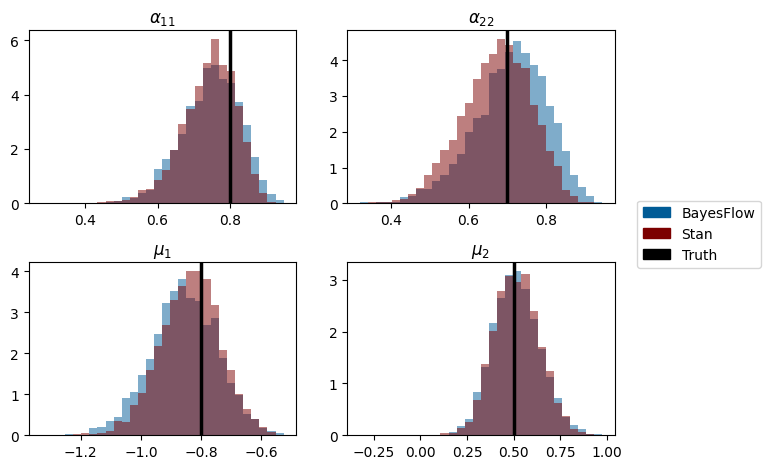

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()

bins = [
    np.linspace(np.min(bf_posterior[:,i]), np.max(bf_posterior[:,i]), 31) for i in range(4)
]
for i, par in enumerate(model.param_names['constrained']):
    axs[i].hist(bf_posterior[:,i], bins = bins[i], alpha=0.5, density=True, color=colors['BayesFlow'])
    axs[i].hist(stan_posterior[:,i], bins = bins[i], alpha=0.5, density=True, color=colors['Stan'])
    #axs[i].hist(prior[:,i], bins = bins[i], alpha=0.3, density=True, label = "Prior")
    axs[i].axvline(true_params[0,i], linewidth=2.5, c=colors['Truth'])
    axs[i].set_title(par)

fig.subplots_adjust(right=0.8)
keys=['BayesFlow', 'Stan', 'Truth']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.1, 0.5), loc='center')
fig.tight_layout()

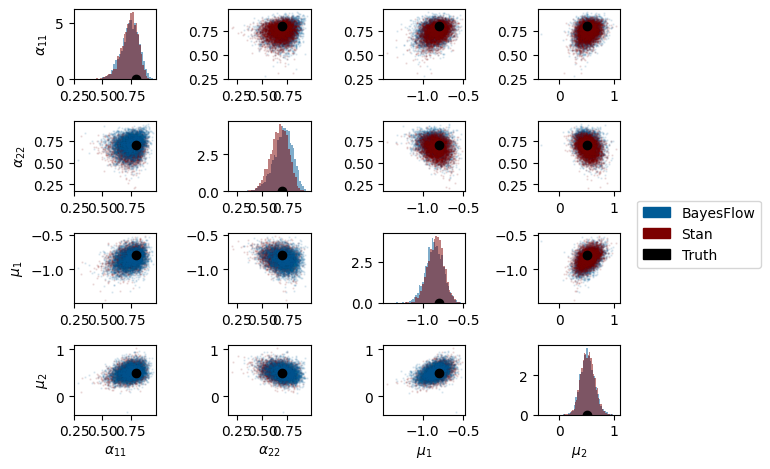

In [11]:
fig, axs = plt.subplots(nrows=len(model.param_names['constrained']), ncols=len(model.param_names['constrained']))
plt.rcParams['figure.figsize'] = [10, 10]

bins = [
    np.linspace(np.min(bf_posterior[:,i]), np.max(bf_posterior[:,i]), 31) for i in range(4)
]

# handles = [
#     patches.Patch(color='skyblue'),
#     patches.Patch(color='darkorange'),
#     patches.Patch(color='black')
# ]
for xi, x_par in enumerate(model.param_names['constrained']):
    axs[-1,xi].set_xlabel(x_par)
    for yi, y_par in enumerate(model.param_names['constrained']):
        if xi == yi:
            axs[yi,0].set_ylabel(y_par)
            axs[yi,xi].hist(bf_posterior[:,xi], bins=40,alpha = 0.5, density=True, color=colors['BayesFlow'])
            axs[yi,xi].hist(stan_posterior[:,xi], bins=40,alpha = 0.5, density=True, color=colors['Stan'])
            axs[yi,xi].scatter(true_params[0,xi], 0, color=colors['Truth'])
        elif xi > yi:
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, color=colors['BayesFlow'])
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, color=colors['Stan'])
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color=colors['Truth'])
        else:
            axs[yi,xi].scatter(bf_posterior[:,xi], bf_posterior[:,yi], s=0.5, alpha=0.1, color=colors['BayesFlow'], zorder=2)
            axs[yi,xi].scatter(stan_posterior[:,xi], stan_posterior[:,yi], s=0.5, alpha=0.1, color=colors['Stan'],zorder=1)
            axs[yi,xi].scatter(true_params[0,xi], true_params[0,yi], color=colors['Truth'], zorder=3)

fig.subplots_adjust(right=0.8)
keys=['BayesFlow', 'Stan', 'Truth']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.1, 0.5), loc='center')
fig.tight_layout()

## Filtering (forward)

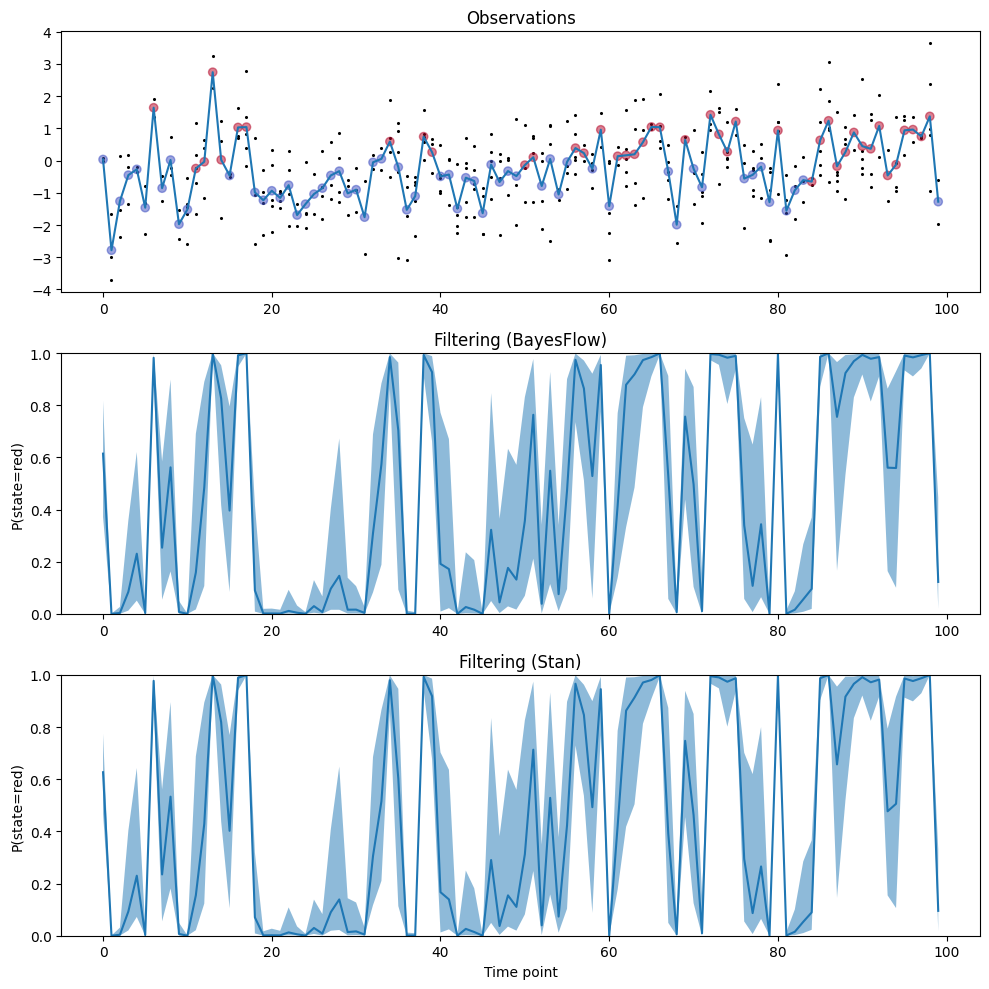

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.set_title("Observations")
means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            ax1.scatter(obs, observables[obs,rep,0], s=1.5, c='black')
    means.append(np.mean(x))

ax1.plot(range(len(observables)), means)
ax1.scatter(range(len(observables)), means, c = latents, cmap='coolwarm', alpha=0.5)


x = range(observables.shape[0])
ax2.set_title("Filtering (BayesFlow)")
ax2.plot(x, forward[1,0,:,1])
ax2.fill_between(
    x,
    forward[0,0,:,1],
    forward[2,0,:,1],
    alpha=0.5
)
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.set_title("Filtering (Stan)")
ax3.plot(x, forward[1,1,:,1])
ax3.fill_between(
    x,
    forward[0,1,:,1],
    forward[2,1,:,1],
    alpha=0.5
)
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

## Backward filtering

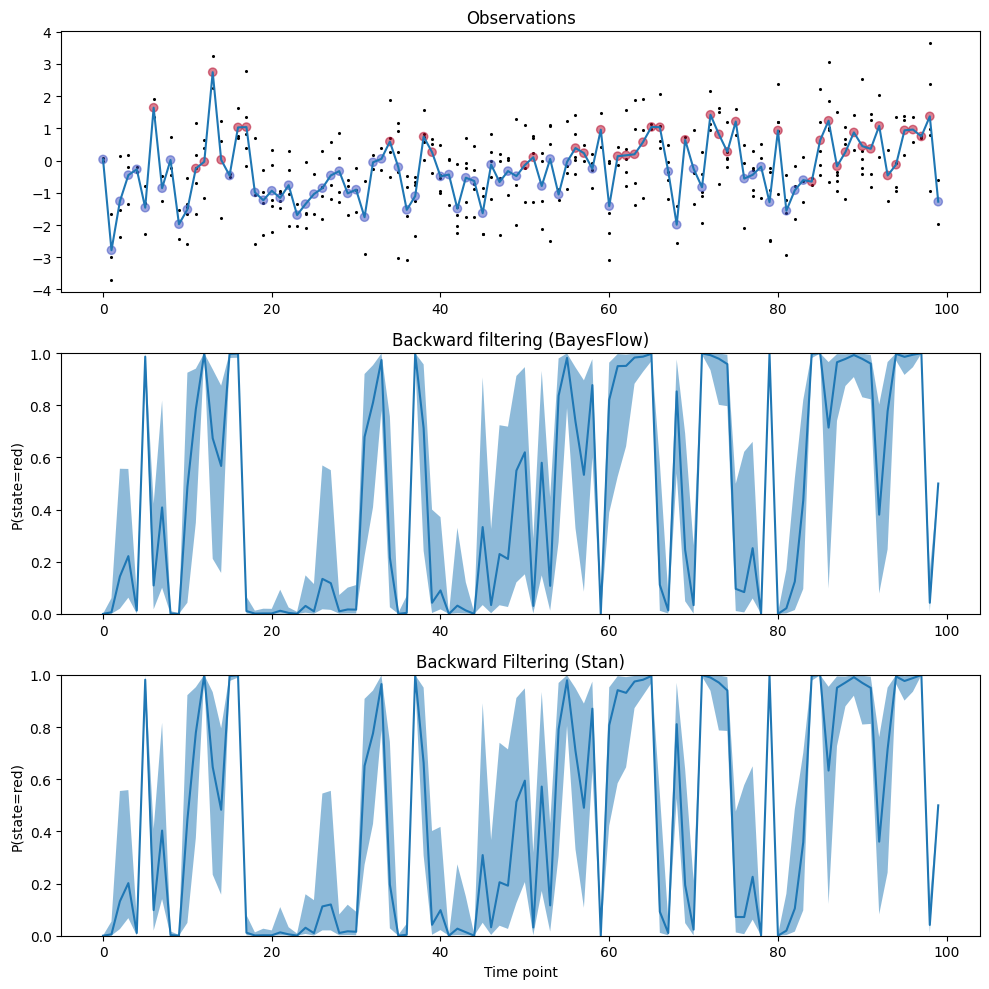

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.set_title("Observations")
means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            ax1.scatter(obs, observables[obs,rep,0], s=1.5, c='black')
    means.append(np.mean(x))

ax1.plot(range(len(observables)), means)
ax1.scatter(range(len(observables)), means, c = latents, cmap='coolwarm', alpha=0.5)


x = range(observables.shape[0])
ax2.set_title("Backward filtering (BayesFlow)")
ax2.plot(x, backward[1,0,:,1])
ax2.fill_between(
    x,
    backward[0,0,:,1],
    backward[2,0,:,1],
    alpha=0.5
)
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.set_title("Backward Filtering (Stan)")
ax3.plot(x, backward[1,1,:,1])
ax3.fill_between(
    x,
    backward[0,1,:,1],
    backward[2,1,:,1],
    alpha=0.5
)
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

## Smoothing

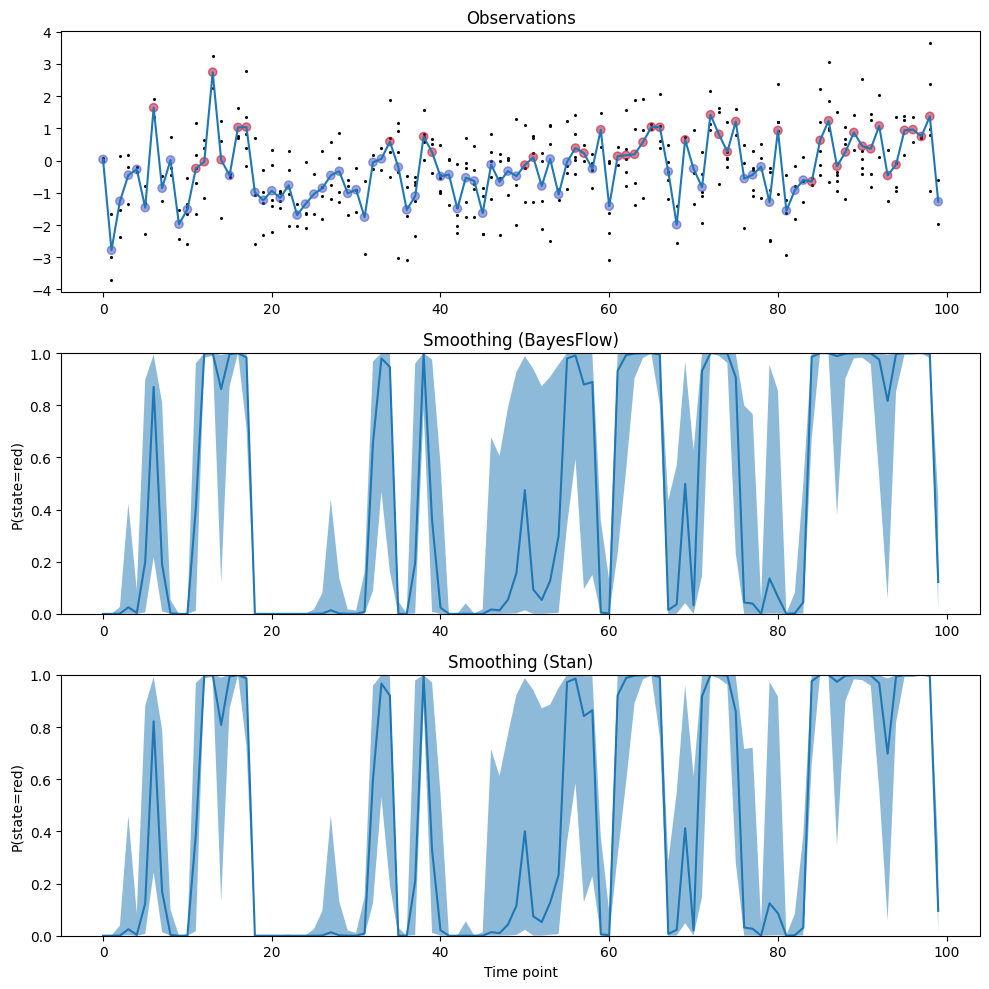

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.set_title("Observations")
means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            ax1.scatter(obs, observables[obs,rep,0], s=1.5, c='black')
    means.append(np.mean(x))

ax1.plot(range(len(observables)), means)
ax1.scatter(range(len(observables)), means, c = latents, cmap='coolwarm', alpha=0.5)


x = range(observables.shape[0])
ax2.set_title("Smoothing (BayesFlow)")
ax2.plot(x, smoothing[1,0,:,1])
ax2.fill_between(
    x,
    smoothing[0,0,:,1],
    smoothing[2,0,:,1],
    alpha=0.5
)
ax2.set_ylabel("P(state=red)")
ax2.set_ylim([0, 1])


ax3.set_title("Smoothing (Stan)")
ax3.plot(x, smoothing[1,1,:,1])
ax3.fill_between(
    x,
    smoothing[0,1,:,1],
    smoothing[2,1,:,1],
    alpha=0.5
)
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
ax3.set_ylim([0, 1])

fig.tight_layout()

## All together

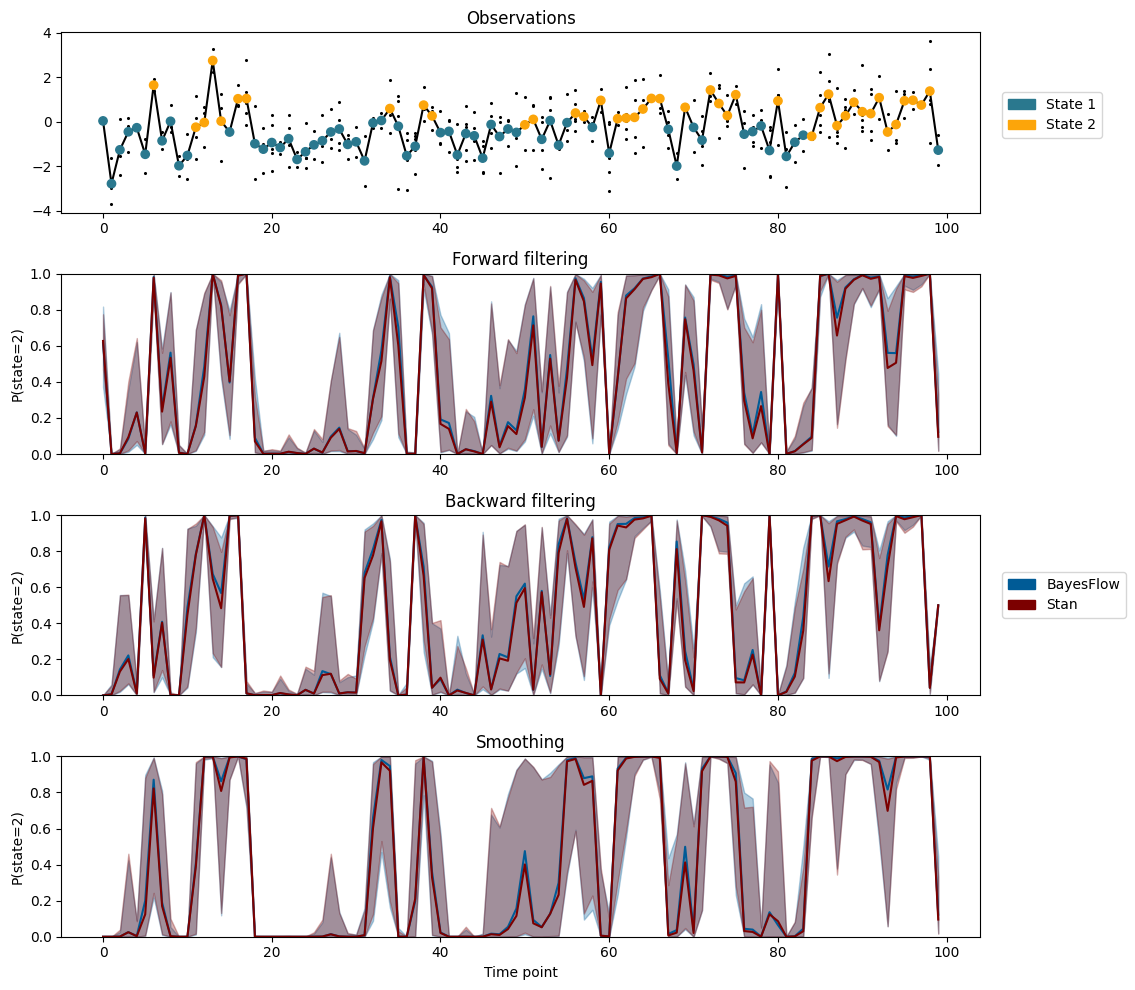

In [16]:
fig, axs = plt.subplots(4, 1)

# observations
axs[0].set_title("Observations")
means = []
for obs in range(observables.shape[0]):
    x = []
    for rep in range(observables.shape[1]):
        valid = observables[obs,rep,1]
        if valid != 0.0:
            x.append(observables[obs,rep,0])
            axs[0].scatter(obs, observables[obs,rep,0], s=1.5, c='black')

    means.append(np.mean(x))

axs[0].plot(range(len(observables)), means, zorder=-1, color='black')
c = [colors["State " + str(int(i+1))] for i in latents]
axs[0].scatter(range(len(observables)), means, color = c)

x = range(observables.shape[0])

for i, type in enumerate(['Forward filtering', 'Backward filtering', 'Smoothing']):
    probs = {'Forward filtering': forward, 'Backward filtering': backward,'Smoothing': smoothing}[type]
    axs[i+1].set_title(type)
    for j, method in enumerate(['BayesFlow', 'Stan']):
        
        axs[i+1].plot(x, probs[1,j,:,1], color=colors[method])
        axs[i+1].fill_between(
            x,
            probs[0,j,:,1],
            probs[2,j,:,1],
            alpha=0.3,
            color=colors[method]
        )
        axs[i+1].set_ylabel("P(state=2)")
        axs[i+1].set_ylim([0, 1])

axs[i+1].set_xlabel("Time point")

keys=['State 1', 'State 2']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.0, 0.88), loc='center left')


fig.subplots_adjust(right=0.8)
keys=['BayesFlow', 'Stan']
handles=[patches.Patch(color=colors[k]) for k in keys]
fig.legend(handles, keys, bbox_to_anchor=(1.0, 0.4), loc='center left')
fig.tight_layout()
